In [9]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
%matplotlib notebook
import matplotlib.pyplot as plt
from utils.multi_slice_viewer import multi_slice_viewer
import os, json
import numpy as np
from scipy.spatial import Delaunay, Voronoi
import pandas as pd
from skimage.measure import regionprops_table
import glob

### Primary functions

#### Shape based feature extractor. This is the primary feature extractor used to grab geometric features from segmented nuclei. The properties from each labeled nuclei is output as a pandas dataframe for convenience. 

In [134]:


def getObjectProperties(labeled_image):
    
    """
    Returns labeled object properties in a pandas DataFrame for convienient sorting.
    
    
    Parameters 
    ----------
    
    labled_image : 3D numpy array
        Segmented image of nuclei where each individual object has been assigned a 
        unique integer idea.
        
    
    Returns
    -------
    
    object_props : pd.DataFrame
        DataFrame object with selected properties extracted using skimage.measure.regionprops_table
    
    
    
    """
    
    #object properties for extraction
    properties=[ 'equivalent_diameter', 'inertia_tensor',
                'inertia_tensor_eigvals', 'major_axis_length',
                'minor_axis_length', 'moments',
                'moments_central', 'label', 'area',
                'solidity', 'feret_diameter_max'
                'moments_normalized', 'centroid', 'bbox', 
                'bbox_area', 'extent',
                'convex_area', 'convex_image']
    
    #extract features and return as dataframe
    object_props = pd.DataFrame(regionprops_table(labeled_image,properties=properties))
    return object_props

#### Centroid reorganization - graph based features are constructed using a set of nodes, in this case the centroids of segmented nuclei. This method reorganizes the centroids and labels extracted from the above method into a 4D array. The array is the entire set of 3D points corresponding to centroid location of segmented nuclei in the labeled image. 

In [3]:
def getCentroids(proptable):
    
    """
    Returns labeled object centroids and labels in a dictionary.
    
    
    Parameters 
    ----------
    
    proptable : pd.DataFrame
        labeled object properties with centroid & label columns
    
    
    Returns
    -------
    
    props_dict : dict
        Dictionary with 'centroids' and 'labels' as keys, with corresponding
    centroids and labels extracted from proptable as numpy arrays.
    """
    
    props_dict = {}
    
    #get centroid column titles
    filter_col = [col for col in proptable if col.startswith('centroid')]
    
    props_dict['centroids'] = proptable[filter_col].to_numpy().astype(int)
    props_dict['labels'] = proptable['label'].to_numpy()
    
    return props_dict

#### Graph based feature extraction - the following method extracts graph based features (Delaunay & Voronoi diagrams) using the set of nuclear centroids as the input.

In [4]:

def getTesselations(centroids):
    
    """
    Return two graph based features from the scipy.spatial module
    
    
    Parameters
    ----------
    
    centroids : numpy array
        Array of centroids extracted from segmented nuclei
        
        
    Returns
    -------
    
    tesselD : scipy.spatial.Delaunay
        Fully connected graph based feature where nuclear centroids are
    input as nodes on the graph.
    
    tesselV : scipy.spatial.Voronoi
        Region based graph (derived from Delaunay) where individual regions
    are grown from points i.e nuclear centroids.
    
    """
    
    #extract delaunay diagram from scipy.spatial 
    tesselD = Delaunay(centroids)
    
    #extract voronoi diagram from scipy.spatial
    tesselV = Voronoi(centroids)
    
    return tesselD, tesselV
    

In [5]:
def cropImage(image, image_props, object_label, clean=False):
    """
    crops section of input image based on bounding box of labeled objects

    labeled objects are determined by the object_label which is a label in a
    property table
    
    
    Parameters
    ----------
    
    image : 3D numpy array
        labeled segmented image of nuclei
        
    image_props : pd.DataFrame
        pandas dataframe of properties with label and bbox as extracted features
        
    object_label : int
        label of object to crop from input image
        
    clean : bool, optional
        clear objects without input label
        
    
    Returns
    -------
    
    crop : 3D numpy array
        cropped region containing the labeled object, crop coordinates are 
    based on the bounding box.

    """

    assert(type(object_label) == int)

    prop = image_props.loc[image_props['label'] == object_label]

    if len(image.shape) == 2:
        coords = [prop['bbox-0'].values[0], prop['bbox-2'].values[0], 
                  prop['bbox-1'].values[0], prop['bbox-3'].values[0]]
        print(coords)

        crop = copy.deepcopy(image[coords[0]:coords[1], coords[2]:coords[3]])

    else:
        coords = [prop['bbox-0'].values[0], prop['bbox-3'].values[0], 
                  prop['bbox-1'].values[0], prop['bbox-4'].values[0],
                  prop['bbox-2'].values[0], prop['bbox-5'].values[0]]
        crop = copy.deepcopy(image[coords[0]:coords[1],
                             coords[2]:coords[3],
                             coords[4]:coords[5]])

    if clean:
        crop = np.ma.masked_where(crop != object_label, crop).filled(0)
        crop = (crop > 0).astype(int)
    return crop

In [101]:
def fullworkflow(filename, min_size=150, return_objects=False):
    
    data = imread(filename)
    
    data = remove_small_objects(data, min_size=min_size)
    
    properties = getObjectProperties(data)
    
    centroids = getCentroids(properties)
    
    tesselD, tesselV = getTesselations(centroids['centroids'])
    
    graphs = {'delaunay' : tesselD.__dict__,
              'voronoi' : tesselV.__dict__}
    
    
    for gkey, gvalue in graphs.items():
        for key,value in gvalue.items():
            
            if type(value) == np.ndarray:
                graphs[gkey][key] = value.tolist()
    
    savedir = filename.split('.tif')[0] + '_features'
    
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    
    prop_filename = os.path.join(savedir, 'region_properties.csv')
    json_filename = os.path.join(savedir, 'graphs.json')
    
    properties.to_csv(prop_filename)
    
    with open(json_filename,'w') as f:
        thestring = json.dumps(graphs)
        json.dump(thestring, f, indent=4, sort_keys=True)
    f.close()
    
    if return_objects:
        return properties, graphs
    
    else: 
        return
    
    
def loadPropTable(filepath):
    return pd.read_csv(filepath)

### Load example labeled 3D data from disk

In [13]:
data_file = os.path.join('./data/region1_3D_crop.tif')
data = imread(data_file)

print(data_file.split('.tif')[0] + '_features' + os.sep)

./data/region1_3D_crop_features\


### Display 3D data using multi-slice-viewer (use j & k keys to pan through volume)

<IPython.core.display.Javascript object>


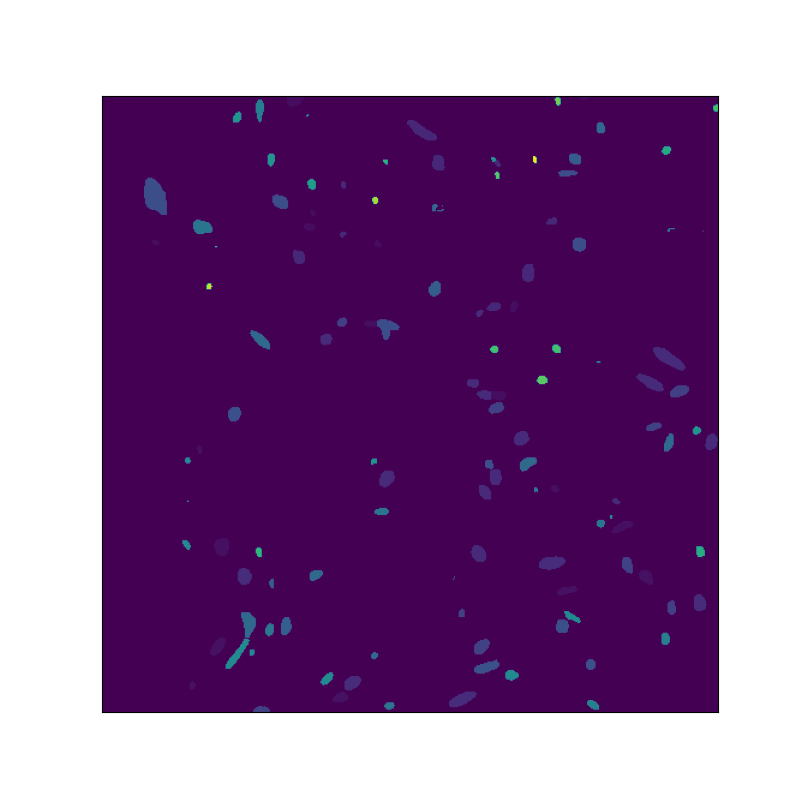

In [16]:
multi_slice_viewer(data, figsize= (8,8))

In [35]:
fullworkflow(data_file)

### Extract shape based features

In [52]:


data = remove_small_objects(data, min_size=150)

properties = getObjectProperties(data)

In [8]:
min(properties['area'])

151

In [123]:
csvfile = "T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP segmentations/region1_x_100_200_diam17_features/region_properties.csv"

properties = loadPropTable(csvfile)

In [161]:
import matplotlib.mlab as mlab
from scipy.stats import norm

def getDistributionPlot(proptable,key,nbins=100):
    
    data = proptable[key]
    data_hist,edges = np.histogram(data, bins=nbins)
    
    mu, sigma = norm.fit(data)
    plt.subplots()
    
    n, bins, patches = plt.hist(proptable[key], 100, alpha = 0.7, edgecolor='k')
    y = norm.pdf(bins, np.median(data), sigma)
    l = plt.plot(bins, (y/y.max())*data_hist.max(), 'r--', linewidth=2)
    
    if key == 'area':
        key = 'volume'
    
    if key == 'convex_area':
        key = 'convex volume'
        
    if '_' in key:
        key = list(key)
        
        for i,char in enumerate(key):
            if char == '_':
                key[i] = '\ '
        key = "".join(key)
    
    plt.xlabel('Nuclear %s'%(key))
    plt.title(r'$\mathrm{Histogram\ of\ Nuclear\ %s:}\ \mu=%.2f,\ \sigma=%.2f$' %(key, mu, sigma))
    plt.grid(True,axis='both', alpha = .7, linestyle='--')
    plt.show()

<IPython.core.display.Javascript object>


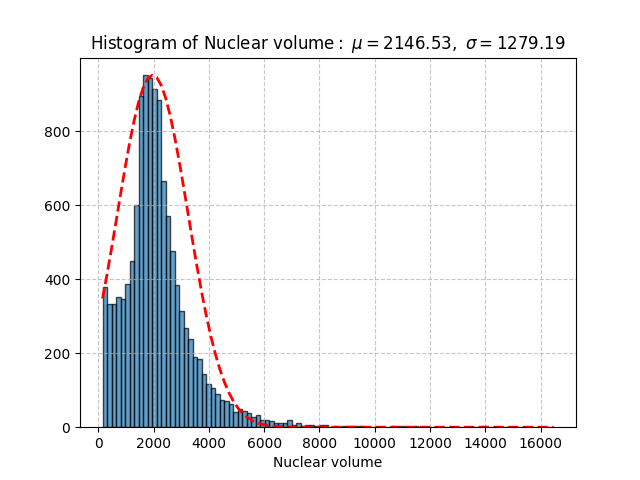

In [164]:
getDistributionPlot(properties,'area')

1756.28418230563 943.6470361803144


<IPython.core.display.Javascript object>


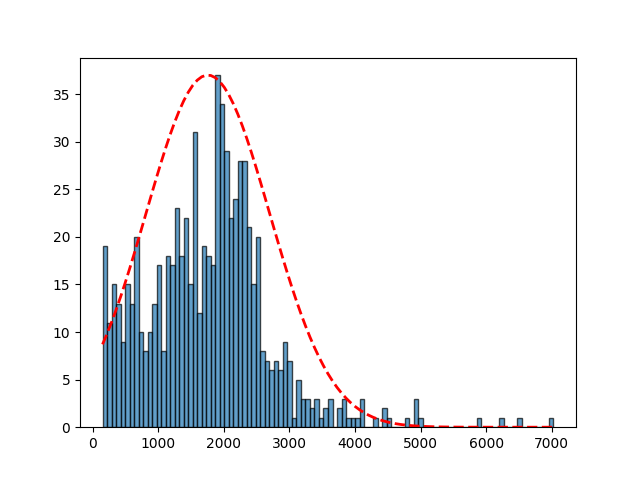

In [72]:
import matplotlib.mlab as mlab
from scipy.stats import norm


volume_hist, edges = np.histogram(properties['area'], bins = 100)

(mu, sigma) = norm.fit(properties['area'])
print(mu, sigma)
plt.subplots()

n, bins, patches = plt.hist(properties['area'], 100, alpha = 0.7, edgecolor='k')
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, (y/y.max())*volume_hist.max(), 'r--', linewidth=2)

In [122]:
cropped_hull = np.asarray(properties[properties['area'] == properties['area'].max()]['convex_image'])

cropped_hull

array(['[[[False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]\n  ...\n  [False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]]\n\n [[False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]\n  ...\n  [False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]]\n\n [[False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]\n  ...\n  [False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]]\n\n ...\n\n [[False False False ... False False False]\n  [False False False ... False False False]\n  [False False False ... False False False]\n  ...\n  

<IPython.core.display.Javascript object>


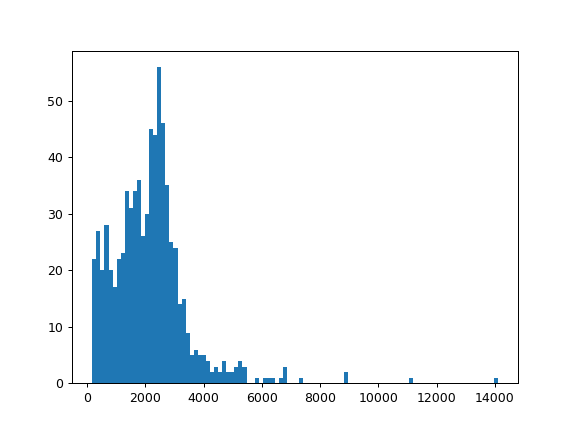

(array([22., 27., 20., 28., 20., 17., 22., 23., 34., 31., 34., 36., 26.,
        30., 45., 44., 56., 46., 35., 25., 24., 14., 15.,  9.,  5.,  6.,
         5.,  5.,  4.,  2.,  3.,  2.,  4.,  2.,  2.,  3.,  4.,  3.,  0.,
         0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  172.  ,   311.45,   450.9 ,   590.35,   729.8 ,   869.25,
         1008.7 ,  1148.15,  1287.6 ,  1427.05,  1566.5 ,  1705.95,
         1845.4 ,  1984.85,  2124.3 ,  2263.75,  2403.2 ,  2542.65,
         2682.1 ,  2821.55,  2961.  ,  3100.45,  3239.9 ,  3379.35,
         3518.8 ,  3658.25,  3797.7 ,  3937.15,  4076.6 ,  4216.05,
         4355.5 ,  4494.95,  4634.4 ,  4773.85,  4913.3 ,  5052.75,
         5192.2 ,  5331.65

In [10]:
from skimage.measure import marching_cubes, mesh_surface_area
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

verts, faces, normals, values = marching_cubes(cropped_hull, spacing=(1,1,1))


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
mesh.set_facecolor('r')
ax.add_collection3d(mesh)


ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 50)  # b = 10
ax.set_zlim(0, 30)  # c = 16

plt.tight_layout()
plt.show()

### Collect nuclear centroids

In [11]:
centroids = getCentroids(properties)

### Extract graph-based tesselations

In [12]:
tesselD, tesselV = getTesselations(centroids['centroids'])

In [45]:
cp_files = sorted(glob.glob('T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests' \
                            + os.sep + '*.tif'))
print(cp_files[-1])

T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_905_1005_3D.tif


In [39]:
fullworkflow(cp_files[0])

In [46]:
for item in cp_files:
    print(item)
    fullworkflow(item)

T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_1005_1105_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_105_205_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_1105_1205_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_1205_1305_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_205_305_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_305_405_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_405_505_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_505_605_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S018_A/CP Segmentation Tests\region1_diam22_imZ_5_105_3D.tif
T:/Rob/Nuclear Segmentation/Cancer Regions

In [49]:
cp_files = sorted(glob.glob('T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations' \
                            + os.sep + '*.tif'))
print(cp_files[-1])

T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_900_1000_diam17.tif


In [50]:
for item in cp_files:
    print(item)
    fullworkflow(item)

T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_0_100_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1000_1100_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_100_200_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1100_1200_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1200_1300_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1300_1400_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1400_1500_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1500_1600_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1600_1700_diam17.tif
T:/Rob/Nuclear Segmentation/Cancer Regions/S039_A/CP Segmentations\region1_x_1700_1800_diam17.tif
T:/Rob/Nuclear Segmentatio

In [168]:
i = 100
'{:0>6d}_{:0>6d}.tif'.format(i,i+100)

'000100_000200.tif'